<h2>Deep Learning with Keras and Tensorflow Project: Pet Classification</h2>
<h2>Kanaishk Garg</h2>
<h2>rishi.gupta90@gmail.com</h2>

<h4>Project Objective:</h4>

Build a CNN model that classifies the given pet images correctly into dog and cat images. 
The project scope document specifies the requirements for the project “Pet Classification Model Using CNN.” Apart from specifying the functional and non-functional requirements for the project, it also serves as an input for project scoping. 

<h4>Project Description and Scope: </h4>

You are provided with a collection of images of pets, that is, cats and dogs. These images are of different sizes with varied lighting conditions and they should be used as inputs for your model.
You are expected to write the code for CNN image classification model using TensorFlow that trains on the data and calculates the accuracy score on the test data. 

<h4>Project Guidelines:</h4>

Begin by creating the ipynb file in the same parent folder where the downloaded data set is kept. The CNN model should have the following layers: 
<ul>
<li>Input layer </li>
<li>Convolutional layer 1 with 32 filters of kernel size[5,5] </li>
<li>Pooling layer 1 with pool size[2,2] and stride 2 </li>
<li>Convolutional layer 2 with 64 filters of kernel size[5,5] </li>
<li>Pooling layer 2 with pool size[2,2] and stride 2 </li>
<li>Dense layer whose output size is fixed in the hyper parameter: fc_size=32 </li>
<li>Dropout layer with dropout probability 0.4 </li>
</ul>

Predict the class by doing a softmax on the output of the dropout layers. 
This should be followed by training and evaluation: 
<ul>
<li>For the training step, define the loss function and minimize it </li>
<li>For the evaluation step, calculate the accuracy </li>
</ul>
Run the program for 100, 200, and 300 iterations, respectively. Follow this by a report on the final accuracy and loss on the evaluation data. 

<h3>Importing the libraries</h3>

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pydot
import cv2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

In [4]:
from keras.utils.vis_utils import plot_model

The code begins by importing the necessary libraries for the task, such as TensorFlow and Keras, as well as other utilities like pydot and cv2. It also sets up the environment and handles any warning suppression.

<h3>Hyperparameters</h3>

In [5]:
fc_size = 32
dropout_prob = 0.4
num_iterations = [100, 200, 300]
l2_regularization = 0.0015

Configuration parameters are defined to control various aspects of the model. These include the size of fully connected layers (fc_size), dropout probability (dropout_prob), the number of iterations to train the model (num_iterations), and the strength of L2 regularization (l2_regularization).

<h3>Importing the dataset</h3>

In [6]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,'Dataset')
model_dir = os.path.join(cwd,'Model')
graph_dir = os.path.join(cwd,'Graphs')
train_path = os.path.join(dataset_dir,'train')
test_path = os.path.join(dataset_dir,'test')

The file paths for the dataset, model, and graphs are specified using the current working directory (cwd) and appropriate subdirectories.

In [7]:
train_datagen = ImageDataGenerator(brightness_range=[0.2,0.5],
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   validation_split = 0.2)
test_datagen = ImageDataGenerator()

An ImageDataGenerator object called train_datagen is created to apply data augmentation techniques during the training phase. This includes brightness adjustments, shearing, zooming, flipping, rotation, and shifting. The test_datagen object is also created, which will be used for testing without augmentation.

In [8]:
train_dataset = train_datagen.flow_from_directory(train_path, 
                                                  target_size=(225, 225), 
                                                  batch_size=8,
                                                  color_mode='rgb',
                                                  subset='training')

Found 32 images belonging to 2 classes.


In [9]:
valid_dataset = train_datagen.flow_from_directory(train_path, 
                                                  target_size=(225, 225), 
                                                  batch_size=8,
                                                  color_mode='rgb',
                                                  subset='validation')

Found 8 images belonging to 2 classes.


Two data generators, train_dataset and valid_dataset, are initialized using the train_datagen object. These generators load images from the training directory, resize them to the desired dimensions (225x225 pixels), and create mini-batches of images along with their corresponding labels. The valid_dataset is a subset of the training data and is used for validation during training.

In [10]:
test_dataset = test_datagen.flow_from_directory(test_path, 
                                                target_size=(225, 225),
                                                batch_size=4,
                                                color_mode = 'rgb')

Found 20 images belonging to 2 classes.


Another data generator, test_dataset, is created using the test_datagen object. This generator loads images from the testing directory and prepares them for evaluation.

<h3>Building the model with Softmax</h3>

In [11]:
def model_def() :
    model = keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=(225, 225, 3), kernel_regularizer=l2(l2_regularization)),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(l2_regularization)),
        layers.MaxPooling2D(pool_size=(2,2), strides=2),
        layers.Flatten(),
        layers.Dense(units=fc_size, activation='relu', kernel_regularizer=l2(l2_regularization)),
        layers.Dropout(dropout_prob),
        layers.Dense(2, activation='softmax', kernel_regularizer=l2(l2_regularization))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

The model_def function is defined to construct the architecture of the convolutional neural network (CNN). It comprises several layers, including convolutional layers with ReLU activation, max pooling layers, a flatten layer, fully connected layers with ReLU activation, dropout regularization, and a final softmax output layer. The model is compiled with the Adam optimizer and the categorical cross-entropy loss function.

<h3>Training the model</h3>

In [12]:
def model_testing(model, train_dataset, valid_dataset, iterations, graph_dir=graph_dir) :
    lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=0)
    plot_model(model,to_file=os.path.join(graph_dir,f'Pet_Classification_CNN_{iterations}_Softmax_Adam.png'),show_shapes=True,show_layer_names=True)
    print(f"Training for {iterations} iterations")
    history = model.fit(train_dataset, epochs=iterations, validation_data=valid_dataset, verbose=0, callbacks=[lr_scheduler])
    
    max_acc_val=max(history.history['val_accuracy'])*100
    print(f'Maximum Validation Accuracy obtained is {max_acc_val}%')
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    title = f'Model Accuracy for {iterations} iterations Softmax Adam'
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'])
    plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
    plt.show()
    plt.close()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    title = f'Model Loss for {iterations} iterations Softmax Adam'
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Valid'])
    plt.savefig(os.path.join(graph_dir,title+'.png'), bbox_inches='tight')
    plt.show()
    plt.close()
    
    model.save(os.path.join(model_dir,f'Pet_Classification_CNN_{iterations}_Softmax_Adam.h5'))

The model_testing function takes a model, training dataset, validation dataset, and the number of iterations as inputs. Within this function, a learning rate scheduler using the ReduceLROnPlateau callback is created. The model is trained for the specified number of iterations using the training dataset while monitoring the validation accuracy. After training, the model is saved, and the accuracy and loss curves are plotted using Matplotlib.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 179776)            0         
                                                                 
 dense (Dense)               (None, 32)                5

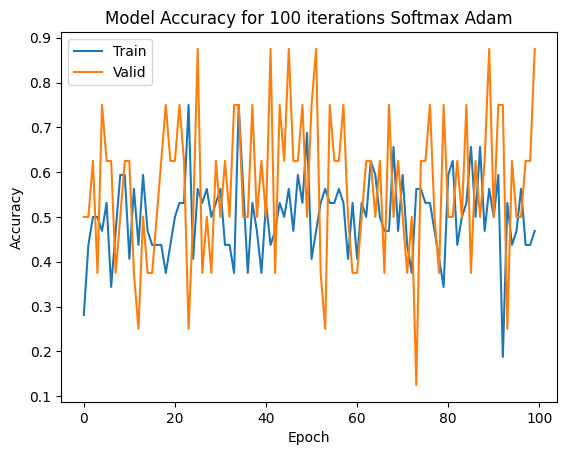

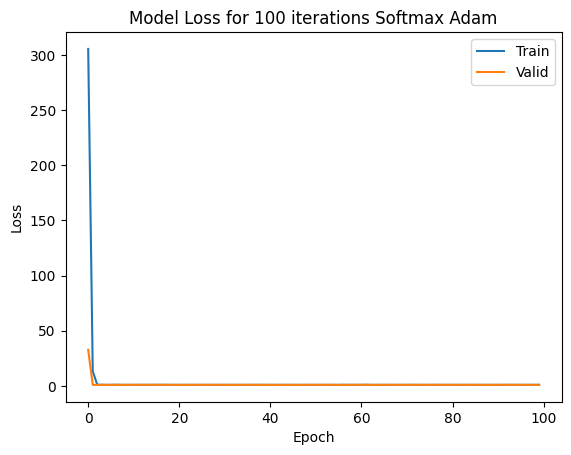

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 221, 221, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 179776)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

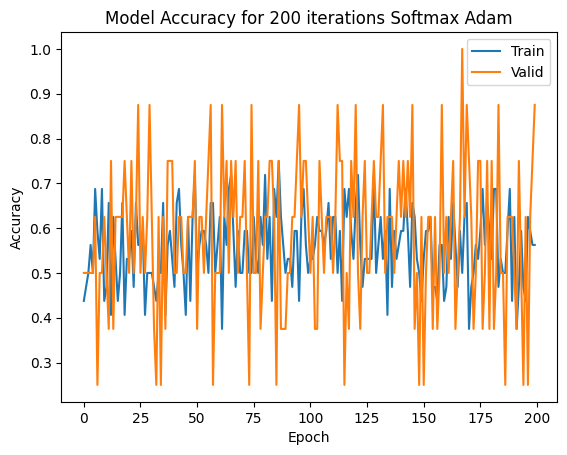

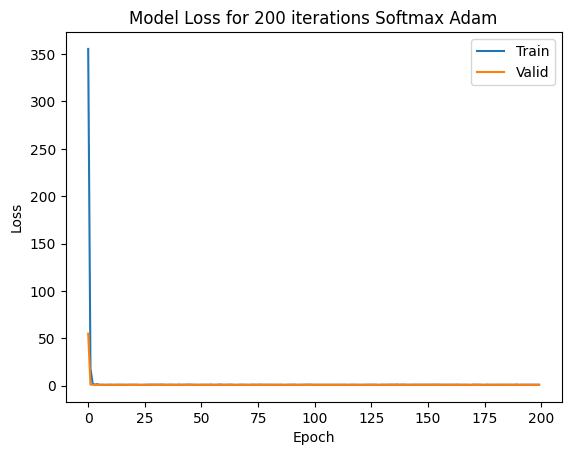

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 221, 221, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 179776)            0         
                                                                 
 dense_4 (Dense)             (None, 32)               

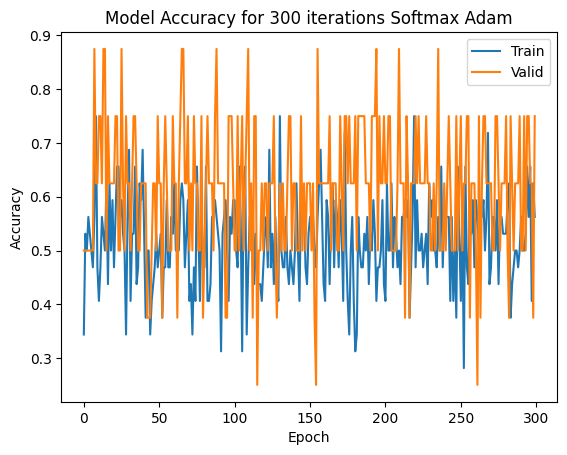

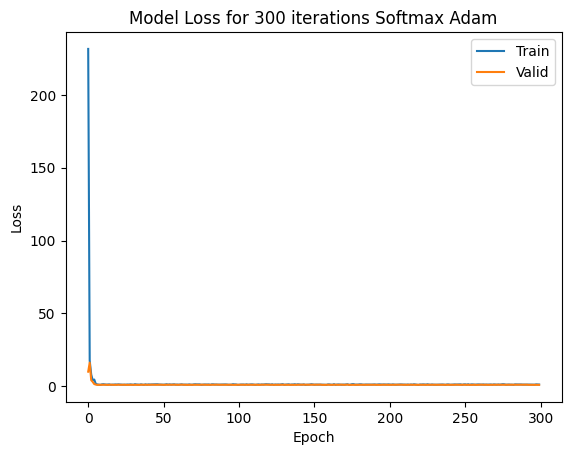

In [13]:
for iterations in num_iterations :
    model = model_def()
    model.summary()
    model_testing(model, train_dataset, valid_dataset, iterations)

In [15]:
model_files = os.listdir(model_dir)
model_files.remove('.ipynb_checkpoints')
model_files.remove('Trial')

for models in model_files :
    print(models)
    test_loss, test_acc = keras.models.load_model(os.path.join(model_dir,models)).evaluate(test_dataset)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Pet_Classification_CNN_100_Softmax_Adam.h5
5/5 [==============================] - 0s 48ms/step - loss: 0.9810 - accuracy: 0.6000
Test Loss: 0.980996310710907, Test Accuracy: 0.6000000238418579
Pet_Classification_CNN_200_Softmax_Adam.h5
5/5 [==============================] - 0s 43ms/step - loss: 4.6097 - accuracy: 0.5000
Test Loss: 4.6096601486206055, Test Accuracy: 0.5
Pet_Classification_CNN_300_Softmax_Adam.h5
5/5 [==============================] - 0s 42ms/step - loss: 0.9946 - accuracy: 0.4500
Test Loss: 0.9946047067642212, Test Accuracy: 0.44999998807907104


A loop iterates over the num_iterations list, creating a new model in each iteration. The model_testing function is then called to train and evaluate the model using the training and validation datasets. Finally, the performance of the model is evaluated on the separate test dataset, and the test loss and accuracy are printed.

<h2>While I was able to minimize the loss quite well the accuracy is not high. Due to being limited in layers we can implement and the small size of the dataset nothing can be done to improve it without major changes to either the structure or the dataset.</h2>
<h2>During validation model is able to achieve accuracy above 85% but testing shows its only 60% and decrease with increasing number of iterations. This shows model is being overfitted and unable to converge properly. Also softmax activation function does not perform as well as sigmoid activation function. Regularization using l2 helped but it cannot change the reality that dataset is too small. I also tried adding grayscale samples of training images along with normal ones but that also does not improve performance probably due to lack of diversity among the features extracted</h2>
<h2>Overall Model can be improved a lot more if some restrictions of project are relaxed.</h2>